In [1]:
"""CLASS FILE STARTS BELOW"""

'CLASS FILE STARTS BELOW'

In [1]:
from prov.model import *
import prov.model as prov
from http import cookies
import sqlite3 as lite
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
from prov.dot import prov_to_dot
from IPython.display import Image

class ProvManager():
    def __init__(self, output_fp=path.join(os.getcwd(), "results/"), db_fp="/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Crawls/crawl-data.sqlite"):
        self.db_fp = db_fp
        self.output_fp = output_fp
        self.documents = {}
        self.all_tp_hosts = {1: [],
                           2: [],
                           3: [],
                           4: []}
        self.cur = None
        if not path.exists(self.output_fp):
            os.mkdir(self.output_fp)
            
#     if __main__ == "main":
#         main()
        
    def main(self):
        self.db_connect()
        self.create_prov()
        self.record_prov()
        self.write_prov()
        self.all_cookie_stats()
    
    def db_connect(self):
        connection = lite.connect(self.db_fp)
        self.cur = connection.cursor()
    
    def create_prov(self):
        for visit_id in self.cur.execute("select visit_id from site_visits"):
            document = ProvDocument()
            document.set_default_namespace('http://danik.com')
            self.documents[visit_id[0]] = document
#         return document
    
    def retrieve_tp_hosts(self,visit_id, site_url):
        hosts = []
        for h in self.cur.execute("select host from javascript_cookies where visit_id=?", str(visit_id)):
            split = h[0].split('.')
            if 'www' in split: split.remove('www')
            host = split[1]
            for el in split[2:]:
                host += "." + el
            if site_url.find(host) == -1:
                hosts.append(h[0])
        return hosts
    
    def record_prov(self):        
        for visit, doc in self.documents.items():
            tp_hosts = []
            doc.agent('OpenWPM', {'prov:type': 'prov:SoftwareAgent'})
            doc.agent('user')
            doc.activity('performCrawl')
            doc.entity('visit%d'%visit)
            self.cur.execute("select site_url from site_visits where visit_id=?",str(visit))
            site_url = self.cur.fetchone()[0][7:]
            doc.entity(site_url)
            doc.entity('syncing_algorithm')
            doc.agent('tracker1')
            doc.agent('tracker2')
            doc.activity('syncCookies')
            doc.activity('collectData')

            tp_cookies = doc.collection('cookies%d'%visit)
        #     tp_cookies.set_default_namespace('http://danik.com/bundles')
#             sync_algorithm = doc.bundle('syncing_algorithm')
        #     sync_algorithm.set_default_namespace('http://danik.com/syncing')


            doc.actedOnBehalfOf('OpenWPM', 'user')
            doc.wasAssociatedWith('performCrawl', 'OpenWPM')
            doc.wasGeneratedBy('visit%d'%visit, 'performCrawl')
            doc.wasDerivedFrom('visit%d'%visit, site_url, 'performCrawl')
            doc.wasAttributedTo(site_url, 'tracker1')
            doc.wasAssociatedWith('collectData', 'tracker1')
            doc.wasGeneratedBy('cookies%d'%visit, 'collectData')
            doc.actedOnBehalfOf('tracker2', 'tracker1', 'syncCookies')
            doc.used('syncCookies', 'cookies%d'%visit)
            doc.used('syncCookies', 'syncing_algorithm')
            doc.used('performCrawl', site_url)
            doc.used('collectData', site_url)

#             for h in cur.execute("select host from javascript_cookies where visit_id=?", str(visit)):
#                 split = h[0].split('.')
#                 if 'www' in split: split.remove('www')
#                 host = split[1]
#                 for el in split[2:]:
#                     host += "." + el
#                 if site_url.find(host) == -1:
#                     tp_hosts.append(h[0])
            tp_hosts = self.retrieve_tp_hosts(visit, site_url)
#             print(tp_hosts)
        #         hosts.append(host)
        #         if host in trackers:
        #             hosts.append(host)
            for tp in tp_hosts:
                e = doc.entity(tp)
                doc.hadMember(tp_cookies, e)
            self.all_tp_hosts[visit] = tp_hosts
        print("finished record:")
        print(self.all_tp_hosts[2])
            
    def write_prov(self):
        for visit, document in self.documents.items():
            dot = prov_to_dot(document)
            dot.write_png(path.join(self.output_fp,'visit%d.png' %visit))
#             file = open(path.join(self.output_fp,'visit%d.png' %visit), 'w+')
#             file.write(dot)
#             file.close()
            print("writing")
#             dot.write_png('visit%d.png' %visit)

    def cookie_stats(self, visit_id, site_url = ""):
        tp_cookies = self.all_tp_hosts[visit_id]
        self.cur.execute("select count(id) from javascript_cookies where visit_id=?", str(visit_id))
        cookies_num = self.cur.fetchone()[0]
        print("This visit resulted in %d cookies being recorded on your browser." % cookies_num)
        if len(tp_cookies) == 0:
            print("None of which are 3rd party")
        else:
            print("Of which %d are 3rd party."%len(tp_cookies))
            print("List of 3rd party trackers: ")
            print(set(tp_cookies))
            self.cookie_pie(cookies_num, len(tp_cookies), site_url)
            
    def all_cookie_stats(self,):
        for vid, cs in self.all_tp_hosts.items():
            self.cur.execute("select site_url from site_visits where visit_id=?",str(vid)) #TODO: Refactor this
            site_url = self.cur.fetchone()[0][7:]
            print("\nVisit %d to %s" % (vid, site_url), end='')
            self.cookie_stats(vid, site_url = site_url)
            
    def cookie_pie(self, num_total, num_tp, site_url=""):
        color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9', 
                              '#C1F0F6', '#0099CC']
        labels = ['1st Party', '3rd Party']
        plt.rcParams['font.sans-serif'] = 'Arial'
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['text.color'] = '#e8001b'
        plt.rcParams['axes.labelcolor']= '#e8001b'
        plt.rcParams['xtick.color'] = '#e8001b'
        plt.rcParams['ytick.color'] = '#e8001b'
        plt.rcParams['font.size']=12
        values = [num_total -num_tp, num_tp]
        explode = (0.1, 0)

        fig, ax = plt.subplots()
        ax.pie(values, labels=labels, explode=explode, colors=color_palette_list[0:2], autopct='%1.0f%%', shadow=False, startangle=90, pctdistance=0.8, labeldistance=1.1)
        ax.axis('equal')
        ax.set_title('Proportion of 3rd party cookies from %s\nTotal number of cookies: %d' %(site_url, num_total))
        ax.legend(frameon=False, bbox_to_anchor=(1.5, 0.8))

In [192]:
provman = ProvManager()

finished record:
['.addthis.com', '.addthis.com', '.addthis.com', '.addthis.com', '.doubleclick.net', '.bing.com', '.doubleclick.net', '.doubleclick.net', '.linkedin.com', '.ads.linkedin.com', '.linkedin.com', '63621.global.siteimproveanalytics.io', '63621.global.siteimproveanalytics.io', '.facebook.com', '.linkedin.com', '.linkedin.com', '.www.linkedin.com', '.linkedin.com']
writing
writing
writing
writing

Visit 1 to facebook.com/kotsios1926
This visit resulted in 0 cookies being recorded on your browser.
None of which are 3rd party

Visit 2 to kcl.ac.uk/people/luc-moreau
This visit resulted in 28 cookies being recorded on your browser.
Of which 18 are 3rd party.
List of 3rd party trackers: 
{'.facebook.com', '.bing.com', '.ads.linkedin.com', '.doubleclick.net', '63621.global.siteimproveanalytics.io', '.addthis.com', '.www.linkedin.com', '.linkedin.com'}

Visit 3 to twitter.com/xQc
This visit resulted in 6 cookies being recorded on your browser.
None of which are 3rd party

Visit 4 t

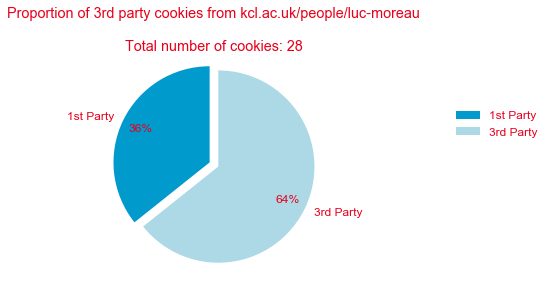

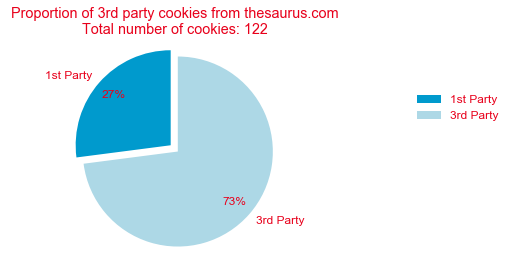

In [193]:
# provman.db_connect("/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Crawls/crawl-data.sqlite")
# provman.create_prov()
# provman.record_prov()
# provman.write_prov()
# provman.all_cookie_stats()
provman.main()

finished record:
['.addthis.com', '.addthis.com', '.addthis.com', '.addthis.com', '.doubleclick.net', '.bing.com', '.doubleclick.net', '.doubleclick.net', '.linkedin.com', '.ads.linkedin.com', '.linkedin.com', '63621.global.siteimproveanalytics.io', '63621.global.siteimproveanalytics.io', '.facebook.com', '.linkedin.com', '.linkedin.com', '.www.linkedin.com', '.linkedin.com']


writing
writing
writing
writing



Visit 1 to facebook.com/kotsios1926
This visit resulted in 0 cookies being recorded on your browser.
None of which are 3rd party

Visit 2 to kcl.ac.uk/people/luc-moreau
This visit resulted in 28 cookies being recorded on your browser.
Of which 18 are 3rd party.
List of 3rd party trackers: 
{'.facebook.com', '.bing.com', '.ads.linkedin.com', '.doubleclick.net', '63621.global.siteimproveanalytics.io', '.addthis.com', '.www.linkedin.com', '.linkedin.com'}

Visit 3 to twitter.com/xQc
This visit resulted in 6 cookies being recorded on your browser.
None of which are 3rd party

Visit 4 to thesaurus.comThis visit resulted in 122 cookies being recorded on your browser.
Of which 89 are 3rd party.
List of 3rd party trackers: 
{'.advertising.com', '.smartadserver.com', '.adsby.bidtheatre.com', '.adform.net', '.prg.smartadserver.com', '.adnxs.com', '.bidswitch.net', 'ssc.33across.com', 'eus.rubiconproject.com', '.doubleclick.net', '.dnacdn.net', '.lijit.com', '.mathtag.com', '.pubmatic.com', '.de

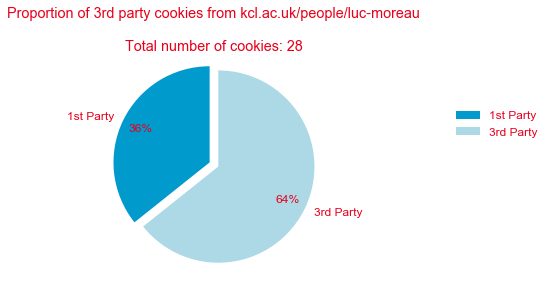

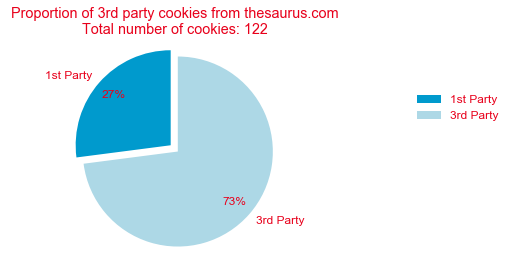

In [18]:
# # for jid,hurl in cur.execute("select j.id, h.url from javascript_cookies as j join http_requests as h on j.visit_id=h.visit_id"):
# #     print((jid,hurl))
# # cur.execute("select h.url, count(j.id) from http_requests as h left join javascript_cookies as j on j.visit_id=h.visit_id group by h.visit_id")
# cur.execute("select s.site_url, count(j.id) from site_visits as s left join javascript_cookies as j on j.visit_id=s.visit_id group by s.visit_id")
# print("All cookies:\n%s" % cur.fetchall())
# cur.execute("select s.site_url, count(j.id) from site_visits as s left join javascript_cookies as j on j.visit_id=s.visit_id where j.is_host_only=0 group by s.visit_id")
# print("3rd party:\n%s" % cur.fetchall())

In [158]:
# documents = {}
# for visit_id in cur.execute("select visit_id from site_visits"):
#     document = provman.create_prov(visit_id[0])
#     documents[visit_id[0]] = document
#     document.set_default_namespace('http://danik.com')

In [159]:
# # trackers = [".addthis.com", ".doublecklick.net"]
# all_tp_hosts = {1: [],
#                2: [],
#                3: [],
#                4: []}
# for visit, doc in documents.items():
#     tp_hosts = []
#     doc.agent('OpenWPM', {'prov:type': 'prov:SoftwareAgent'})
#     doc.agent('user')
#     doc.activity('performCrawl')
#     doc.entity('visit%d'%visit)
#     cur.execute("select site_url from site_visits where visit_id=?",str(visit))
#     site_url = cur.fetchone()[0][7:]
#     doc.entity(site_url)
#     doc.agent('tracker1')
#     doc.agent('tracker2')
#     doc.activity('syncCookies')
#     doc.activity('collectData')
    
#     tp_cookies = doc.collection('cookies%d'%visit)
# #     tp_cookies.set_default_namespace('http://danik.com/bundles')
#     sync_algorithm = doc.bundle('syncing_algorithm')
# #     sync_algorithm.set_default_namespace('http://danik.com/syncing')
    

#     doc.actedOnBehalfOf('OpenWPM', 'user')
#     doc.wasAssociatedWith('performCrawl', 'OpenWPM')
#     doc.wasGeneratedBy('visit%d'%visit, 'performCrawl')
#     doc.wasDerivedFrom('visit%d'%visit, site_url, 'performCrawl')
#     doc.wasAttributedTo(site_url, 'tracker1')
#     doc.wasAssociatedWith('collectData', 'tracker1')
#     doc.wasGeneratedBy('cookies%d'%visit, 'collectData')
#     doc.actedOnBehalfOf('tracker2', 'tracker1', 'syncCookies')
#     doc.used('syncCookies', 'cookies%d'%visit)
#     doc.used('syncCookies', 'syncing_algorithm')
#     doc.used('performCrawl', site_url)
#     doc.used('collectData', site_url)
    
#     for h in cur.execute("select host from javascript_cookies where visit_id=?", str(visit)):
#         split = h[0].split('.')
#         if 'www' in split: split.remove('www')
#         host = split[1]
#         for el in split[2:]:
#             host += "." + el
#         if site_url.find(host) == -1:
#             tp_hosts.append(h[0])
            
# #         hosts.append(host)
# #         if host in trackers:
# #             hosts.append(host)
#     for tp in tp_hosts:
#         e = doc.entity(tp)
#         doc.hadMember(tp_cookies, e)
#     all_tp_hosts[visit] = tp_hosts
# #         print(host[0])
# #     print(doc.namespaces)
# #     doc.e
# #         e = doc.entity('a', 'e', 'g')
# #         print(host[0])

In [11]:
# all_tp_hosts

In [12]:
# cur.execute("select site_url from site_visits where visit_id=?",'2')
# site_url = cur.fetchone()[0][7:]
# print(site_url)
# for h in cur.execute("select host from javascript_cookies where visit_id=?", '2'):
#         split = h[0].split('.')
#         if 'www' in split: split.remove('www')
#         host = split[1]
        
#         for el in split[2:]:
#             host += "." + el
#         if site_url.find(host) == -1:
#             tp_hosts.append(h[0])
#             print(h)

In [155]:
# from prov.dot import prov_to_dot
# from IPython.display import Image
# for visit, document in documents.items():
#     dot = prov_to_dot(document)
#     dot.write_png('visit%d.png' %visit)
#     Image('visit%d.png' %visit)

In [235]:
def cookie_stats(visit_id, site_url = ""):
    tp_cookies = all_tp_hosts[visit_id]
    cur.execute("select count(id) from javascript_cookies where visit_id=?", str(visit_id))
    cookies_num = cur.fetchone()[0]
    print("This visit resulted in %d cookies being recorded on your browser." % cookies_num)
    if len(tp_cookies) == 0:
        print("None of which are 3rd party")
    else:
        print("Of which %d are 3rd party."%len(tp_cookies))
        print("List of 3rd party trackers: ")
        print(set(tp_cookies))
        cookie_pie(cookies_num, len(tp_cookies), site_url)

In [214]:
get_cookie_stats(2)

This visit resulted in 28 cookies being recorded on your browser.
Of which 18 are 3rd party.
List of 3rd party trackers: 
{'63621.global.siteimproveanalytics.io', '.www.linkedin.com', '.doubleclick.net', '.ads.linkedin.com', '.linkedin.com', '.bing.com', '.addthis.com', '.facebook.com'}


In [236]:
def all_cookie_stats():
    for vid, cs in all_tp_hosts.items():
        cur.execute("select site_url from site_visits where visit_id=?",str(vid)) #TODO: Refactor this
        site_url = cur.fetchone()[0][7:]
        print("\nVisit %d to %s" % (vid, site_url), end='')
        cookie_stats(vid, site_url = site_url)


Visit 1 to facebook.com/kotsios1926
This visit resulted in 0 cookies being recorded on your browser.
None of which are 3rd party

Visit 2 to kcl.ac.uk/people/luc-moreau
This visit resulted in 28 cookies being recorded on your browser.
Of which 18 are 3rd party.
List of 3rd party trackers: 
{'63621.global.siteimproveanalytics.io', '.www.linkedin.com', '.doubleclick.net', '.ads.linkedin.com', '.linkedin.com', '.bing.com', '.addthis.com', '.facebook.com'}

Visit 3 to twitter.com/xQc
This visit resulted in 6 cookies being recorded on your browser.
None of which are 3rd party

Visit 4 to thesaurus.comThis visit resulted in 122 cookies being recorded on your browser.
Of which 89 are 3rd party.
List of 3rd party trackers: 
{'.adnxs.com', '.adsby.bidtheatre.com', '.doubleclick.net', '.openx.net', '.pubmatic.com', '.ads.pubmatic.com', '.bidswitch.net', '.de17a.com', '.dnacdn.net', '.adform.net', '.mathtag.com', 'ssc.33across.com', '.dictionary.com', '.advertising.com', '.prg.smartadserver.com'

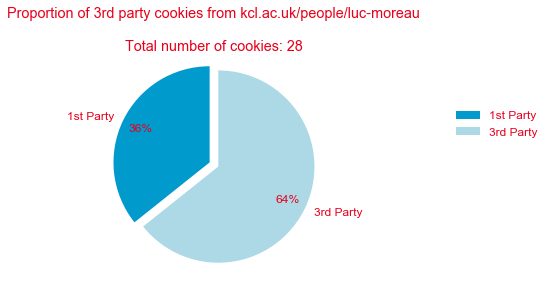

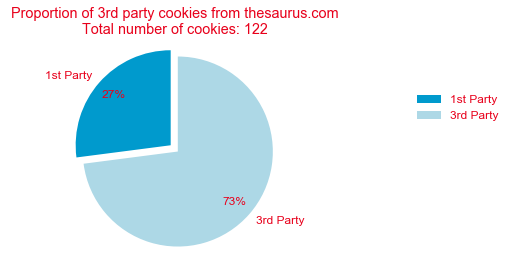

In [243]:
all_cookie_stats()

In [126]:
cookies2 = testdoc.get_records()
type(cookies2)
cookies2
for record in cookies2:
    if type(record) is ProvMembership:
        print(record.attributes[1][1])                                  
        

.twitter.com
.twitter.com
.twitter.com
.twitter.com
.twitter.com
.twitter.com


In [242]:
def cookie_pie(num_total, num_tp, site_url=""):
    color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9', 
                          '#C1F0F6', '#0099CC']
    labels = ['1st Party', '3rd Party']
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['text.color'] = '#e8001b'
    plt.rcParams['axes.labelcolor']= '#e8001b'
    plt.rcParams['xtick.color'] = '#e8001b'
    plt.rcParams['ytick.color'] = '#e8001b'
    plt.rcParams['font.size']=12
    values = [num_total -num_tp, num_tp]
    explode = (0.1, 0)

    fig, ax = plt.subplots()
    ax.pie(values, labels=labels, explode=explode, colors=color_palette_list[0:2], autopct='%1.0f%%', shadow=False, startangle=90, pctdistance=0.8, labeldistance=1.1)
    ax.axis('equal')
    ax.set_title('Proportion of 3rd party cookies from %s\nTotal number of cookies: %d' %(site_url, num_total))
    ax.legend(frameon=False, bbox_to_anchor=(1.5, 0.8))

In [1]:
"""STARTING FULL EXECUTION"""

'STARTING FULL EXECUTION'

In [9]:
path.exists('/Users/Danik/Desktop/KCL/YEAR_3/PRJ/OpenWPM')

True

In [ ]:
def main():
    print("hello world")
if __name__ == "__name__":
    main()

In [10]:
a = [1,2,3]
b = [4,5,6]
a.append(b)
a

[1, 2, 3, [4, 5, 6]]

In [4]:
import sh

In [3]:
con = lite.connect("/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Crawls/crawl-data.sqlite")

In [4]:
cursor = con.cursor()

In [5]:
cursor.execute("select crawl_id from crawl")
last_crawl = max(cursor.fetchall())[0]

In [121]:
hdrs = []
for header in cursor.execute("select headers from http_responses where visit_id=16"):
    hdrs.append(eval(header[0]))


In [122]:
hdrs[0]

[['server', 'nginx'],
 ['date', 'Thu, 09 Apr 2020 12:10:54 GMT'],
 ['content-type', 'text/html; charset=utf-8'],
 ['content-length', '37507'],
 ['x-powered-by', 'Express'],
 ['etag', 'W/"34326-PShiG8N+jjNCdlPXPC8cs139Tb8"'],
 ['content-encoding', 'gzip'],
 ['x-rq', 'lhr2 96 219 3500'],
 ['cache-control', 'max-age=300, must-revalidate'],
 ['age', '562'],
 ['x-cache', 'hit'],
 ['vary', 'Accept-Encoding'],
 ['accept-ranges', 'bytes'],
 ['strict-transport-security', 'max-age=31536000;includeSubdomains;preload'],
 ['X-Firefox-Spdy', 'h2']]

In [123]:
tags = []

In [124]:
for bar in hdrs:
    for foo in bar:
        try:
            if foo[0] not in tags:
                tags.append(foo[0])
        except:
            if foo not in tags:
                tags.append(foo)


In [125]:
tags

['server',
 'date',
 'content-type',
 'content-length',
 'x-powered-by',
 'etag',
 'content-encoding',
 'x-rq',
 'cache-control',
 'age',
 'x-cache',
 'vary',
 'accept-ranges',
 'strict-transport-security',
 'X-Firefox-Spdy',
 'last-modified',
 'expires',
 'x-optim-disabled',
 'x-content-type-options',
 'x-robots-tag',
 'x-permitted-cross-domain-policies',
 'x-xss-protection',
 'via',
 'x-amz-cf-pop',
 'x-amz-cf-id',
 'access-control-allow-origin',
 'access-control-allow-credentials',
 'access-control-allow-headers',
 'alt-svc',
 'set-cookie',
 'access-control-expose-headers',
 'cf-cache-status',
 'expect-ct',
 'cf-ray',
 'p3p',
 'pragma',
 'link',
 'allow',
 'access-control-allow-methods',
 'timing-allow-origin',
 'x-served-by',
 'x-timer',
 'Last-Modified',
 'Accept-Ranges',
 'Content-Type',
 'Vary',
 'Content-Encoding',
 'Cache-Control',
 'Date',
 'Content-Length',
 'Connection',
 'X-CDN',
 'content-security-policy',
 'x-frame-options',
 'x-fb-debug',
 'x-fb-trip-id',
 'x-cache-hit'

In [136]:
big_tags = []
big_hdrs = []

In [137]:
for header in cursor.execute("select headers from http_responses where visit_id=? or ?", ('16','2')):
    big_hdrs.append(eval(header[0]))

In [138]:
for bar in big_hdrs:
    for foo in bar:
        try:
            if foo[0] not in big_tags:
                big_tags.append(foo[0])
        except:
            if foo not in big_tags:
                big_tags.append(foo)

In [139]:
sorted(big_tags)

['AN-X-Request-Uuid',
 'Accept-Ranges',
 'Access-Control-Allow-Credentials',
 'Access-Control-Allow-Headers',
 'Access-Control-Allow-Methods',
 'Access-Control-Allow-Origin',
 'Access-Control-Max-Age',
 'Age',
 'Cache-Control',
 'Cneonction',
 'Connection',
 'Content-Encoding',
 'Content-Length',
 'Content-Range',
 'Content-Type',
 'DCS',
 'Date',
 'ETag',
 'Etag',
 'Expires',
 'Keep-Alive',
 'Last-Modified',
 'Link',
 'P3P',
 'P3p',
 'Pragma',
 'Referrer-Policy',
 'Server',
 'Server-Cache-Control',
 'Server-Surrogate-Control',
 'Set-Cookie',
 'Strict-Transport-Security',
 'Surrogate-Control',
 'Transfer-Encoding',
 'Vary',
 'Via',
 'X-Age',
 'X-Amz-Cf-Id',
 'X-Amz-Cf-Pop',
 'X-AspNet-Version',
 'X-BACKEND-TTL',
 'X-CDN',
 'X-Cache',
 'X-Cache-ASPX',
 'X-Cache-Hits',
 'X-Cacheable',
 'X-Cnection',
 'X-Content-Type-Options',
 'X-Creative-ID',
 'X-FW-Power-By',
 'X-Firefox-Spdy',
 'X-Frame-Options',
 'X-Grace',
 'X-HW',
 'X-Host',
 'X-Origin-Server',
 'X-Permitted-Cross-Domain-Policies',

In [23]:
for h in hdr_list:
    if "Set-Cookie" in h:
        vals = h[1].split(';')

In [50]:
vals = [v.lstrip() for v in vals]
vals[5].split('=')[0]

'HttpOnly'

In [51]:
val_dict = {val.split('=')[0]: (val.split('=')[1] if '=' in val else " ") for val in vals}

In [52]:
val_dict

{'parsely_network_uuid': '7ae36dfd-0deb-46f9-826f-48233e5e605a',
 'Max-Age': '3153600000',
 'Domain': '.config.parsely.com',
 'Path': '/',
 'Expires': 'Sat, 16 Mar 2120 12:10:57 GMT',
 'HttpOnly': ' '}

# DESIGN TEMPLATE

In [15]:
doc = ProvDocument()
doc.set_default_namespace('http://danik.com')
site_url = 'example.com'

In [16]:
doc.agent('OpenWPM', {'prov:type': 'prov:SoftwareAgent'})
doc.agent('user')
# doc.agent('tracker1')
doc.agent('publisher.com')
# if self.cookie_sync():
#     print("There's cookie sync")
#     doc.agent('tracker2')

# Entities
doc.entity('visit', {'id': '1'})
doc.entity('example.com')
# doc.entity('syncing_algorithm')
doc.entity('crawl', {'id': '1',
                     'DNT': 'False'})
doc.entity('Firefox')

# Activities
doc.activity('performCrawl')
# doc.activity('syncCookies')
doc.activity('setCookies')
doc.activity('visitSite')

doc.collection('trackers')
doc.collection('cookies')

# RELATIONS
# Delegations
doc.actedOnBehalfOf('OpenWPM', 'user')
# doc.actedOnBehalfOf('tracker2', 'tracker1', 'syncCookies')

# Associations
doc.wasAssociatedWith('performCrawl', 'OpenWPM')
# doc.wasAssociatedWith('setCookies', 'tracker1')

# Generations
doc.wasGeneratedBy('cookies', 'setCookies')
doc.wasGeneratedBy('visit', 'visitSite')
doc.wasGeneratedBy('crawl', 'performCrawl')
# doc.wasGeneratedBy('trackers', 'visitSite')

# Derivations
doc.wasDerivedFrom('visit', 'example.com', activity='visitSite')

doc.wasStartedBy('visitSite', 'crawl', starter='performCrawl')

# Attributions
doc.wasAttributedTo('example.com', 'publisher.com')

# Usages
# doc.used('syncCookies', 'cookies%d'%visit)
# doc.used('syncCookies', 'syncing_algorithm')
doc.used('visitSite', site_url)
doc.used('setCookies', site_url)
doc.used('performCrawl', 'Firefox')

doc.agent('tracker1.com')
doc.agent('tracker2.com')
doc.hadMember('trackers', 'tracker1.com')
doc.hadMember('trackers', 'tracker2.com')
doc.wasAssociatedWith('setCookies', 'tracker1.com')
doc.wasAssociatedWith('setCookies', 'tracker2.com')
doc.entity('1')
doc.entity('2')
doc.entity('3')
doc.wasAttributedTo('1', 'tracker1.com')
doc.wasAttributedTo('2', 'tracker1.com')
doc.wasAttributedTo('3', 'tracker2.com')
doc.hadMember('cookies', '1')
doc.hadMember('cookies', '2')
doc.hadMember('cookies', '3')


<ProvMembership: (cookies, 3)>

In [8]:
print(doc.get_provn())

document
  default <http://danik.com>
  
  agent(OpenWPM, [prov:type="prov:SoftwareAgent"])
  agent(user)
  agent(publisher)
  entity(visit, [id="1"])
  entity(example.com)
  entity(crawl, [id="1", DNT="False"])
  entity(Firefox)
  activity(performCrawl, -, -)
  activity(setCookies, -, -)
  activity(visitSite, -, -)
  entity(trackers, [prov:type='prov:Collection'])
  entity(cookies, [prov:type='prov:Collection'])
  actedOnBehalfOf(OpenWPM, user, -)
  wasAssociatedWith(performCrawl, OpenWPM, -)
  wasGeneratedBy(cookies, setCookies, -)
  wasGeneratedBy(visit, visitSite, -)
  wasGeneratedBy(crawl, performCrawl, -)
  wasDerivedFrom(visit, example.com, visitSite, -, -)
  wasStartedBy(visitSite, crawl, performCrawl, -)
  wasAttributedTo(example.com, publisher)
  used(visitSite, example.com, -)
  used(setCookies, example.com, -)
  used(performCrawl, Firefox, -)
  agent(tracker1.com)
  agent(tracker2.com)
  hadMember(trackers, tracker1.com)
  hadMember(trackers, tracker2.com)
  wasAssociatedWi

In [17]:
dot = prov_to_dot(doc)
dot.write_png(path.join(os.getcwd(), 'template.png'))

In [18]:
results_fp = "/Users/Danik/Desktop/KCL/YEAR_3/PRJ/Crawls/Results/"

In [53]:
crawl_visits = {}
for crawl in sorted(os.listdir(results_fp)):
    if 'crawl' in crawl:
        crawl_fp = path.join(results_fp, crawl)
        crawl_id = crawl.split('crawl')[1]
        crawl_visits[int(crawl_id)] = None
        for directory in os.listdir(crawl_fp):
            if 'json' in directory:
                json_fp = path.join(crawl_fp, directory)
                visits = []
                for visit in sorted(os.listdir(json_fp)):
                    visits.append(int(visit.split('visit')[1].split('.')[0]))
    
                    crawl_visits[int(crawl_id)] = {visit: None for visit in visits}
#             crawl_visits[crawl_id] = visits
        

In [59]:
crawl_visits[1][2] = {"hi" : "no"}
crawl_visits

{1: {1: None, 2: {'hi': 'no'}, 3: None},
 10: {18: None},
 11: {19: None},
 12: {20: None},
 13: {21: None},
 14: {22: None},
 2: {4: None, 5: None},
 3: {6: None, 7: None},
 4: {8: None, 9: None},
 5: {10: None},
 6: {11: None, 12: None},
 7: {13: None, 14: None},
 8: {15: None, 16: None},
 9: {17: None}}

In [62]:
for visit, js in crawl_visits[1].items():
    if visit == 2:
        print(js['hi'])

no
